In [22]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)

In [ ]:
# === Load Train & test datasets === #
project = Path.cwd().parent
target_folder = project / "0 - data"
train_df = pd.read_excel(target_folder / "train_clean.xlsx", sheet_name="Sheet1")
test_df = pd.read_excel(target_folder / "test_clean.xlsx", sheet_name="Sheet1")

target_col = "Automation Suitable"
drop_cols = ["Task ID", "Task Name"]
drop_cols = [c for c in drop_cols if c in train_df.columns]

X_train = train_df.drop(columns=[target_col] + drop_cols)
y_train = train_df[target_col]

X_test = test_df.drop(columns=[target_col] + drop_cols)
y_test = test_df[target_col]


In [ ]:
# === Load trained model === #
logreg_pipeline = joblib.load(project / "2 - models/logistic_regression_model.pkl")
print("✅ Logistic Regression model loaded.")

✅ Logistic Regression model loaded.


In [ ]:
# === Get Cross-validation accuracy === #
scores = cross_val_score(logreg_pipeline, X_train, y_train, cv=5, scoring="accuracy")
print(f"Cross-validation (train only) accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

Cross-validation (train only) accuracy: 0.8475 ± 0.0348


In [ ]:
# === Predict on train/test === #
y_train_pred = logreg_pipeline.predict(X_train)
y_test_pred = logreg_pipeline.predict(X_test)

print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nConfusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))

Training Accuracy: 0.875
Testing Accuracy: 0.92

Confusion Matrix (Test):
 [[46  8]
 [ 0 46]]

Classification Report (Test):
               precision    recall  f1-score   support

          No       1.00      0.85      0.92        54
         Yes       0.85      1.00      0.92        46

    accuracy                           0.92       100
   macro avg       0.93      0.93      0.92       100
weighted avg       0.93      0.92      0.92       100



In [ ]:
# === Probabilities + Feasibility % === #
proba = logreg_pipeline.predict_proba(X_test)

# Get "Yes" index safely
classes = list(logreg_pipeline.classes_) if hasattr(logreg_pipeline, "classes_") else list(logreg_pipeline.named_steps["model"].classes_)
yes_index = classes.index("Yes") if "Yes" in classes else 1

feasibility_pct = np.round(proba[:, yes_index] * 100, 2)

results = X_test.copy()
results["Actual"] = y_test.values
results["Predicted"] = y_test_pred
results["Feasibility %"] = feasibility_pct
results["Model"] = "Logistic Regression"

results.head(10)

,Time Taken (mins),Complexity (1-5),Frequency,Tool Used,Department,Error Rate (%),Rule-Based Indicator,Process Stability,Data Structure,Actual,Predicted,Feasibility %,Model
0,0.380295,2,Quarterly,Trello,Customer Service,-1.058714,Yes,Medium,Semi-Structured,Yes,Yes,93.36,Logistic Regression
1,-0.652825,2,Ad-Hoc,Slack,Procurement,-1.529068,Yes,Low,Unstructured,No,Yes,77.38,Logistic Regression
2,0.896855,4,Monthly,Jira,Human Resource,-0.552179,No,Medium,Semi-Structured,Yes,Yes,85.04,Logistic Regression
3,-1.418758,3,Quarterly,SAP,Compliance,-0.552179,Yes,Low,Unstructured,No,No,24.20,Logistic Regression
4,-0.243139,2,Ad-Hoc,Google Sheets,IT,0.460891,No,Medium,Structured,No,No,5.21,Logistic Regression
5,1.235290,5,Weekly,Slack,Sales,0.000608,No,Low,Unstructured,Yes,Yes,54.97,Logistic Regression
6,0.647481,1,Monthly,Custom Portal,Compliance,0.641796,Yes,Medium,Semi-Structured,No,No,3.36,Logistic Regression
7,0.540607,5,Ad-Hoc,Excel,IT,-0.190368,No,Medium,Structured,No,No,11.40,Logistic Regression
8,-1.507820,2,Weekly,Google Sheets,IT,-0.262730,Yes,High,Structured,Yes,Yes,75.95,Logistic Regression
9,0.326858,1,Quarterly,Jira,Admin,-1.203438,Yes,Medium,Semi-Structured,Yes,Yes,98.03,Logistic Regression


ROC AUC (Test): 0.9681964573268921


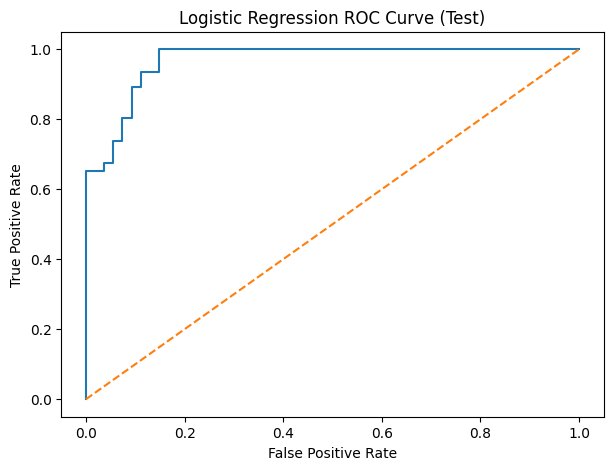

In [ ]:
# === ROC AUC + Curve === #
y_true = (y_test == "Yes").astype(int)
auc = roc_auc_score(y_true, proba[:, yes_index])
print("ROC AUC (Test):", auc)

fpr, tpr, _ = roc_curve(y_true, proba[:, yes_index])

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve (Test)")
plt.show()

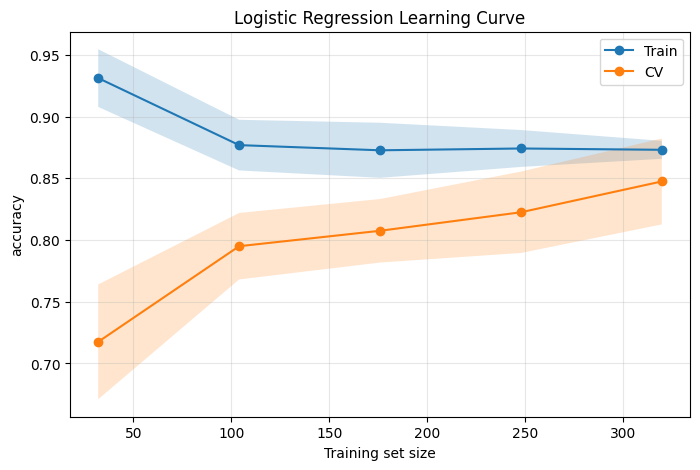

In [ ]:
# === Plot Learning Curve === #
def plot_learning_curve(
    estimator,
    X,
    y,
    title="Learning Curve",
    scoring="accuracy",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
):
    sizes, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=42
    )

    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)

    val_mean = val_scores.mean(axis=1)
    val_std  = val_scores.std(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(sizes, train_mean, marker="o", label="Train")
    plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

    plt.plot(sizes, val_mean, marker="o", label="CV")
    plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel(scoring)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_learning_curve(
    estimator=logreg_pipeline,
    X=X_train,
    y=y_train,
    title="Logistic Regression Learning Curve",
    scoring="accuracy",
    cv=5
)


In [ ]:
# === Save prediction results to CSV === #

export_path = project / "3 - evaluation/logistic_regression_summary.csv"

results_to_save = results.copy()

results_to_save["Model"] = "Logistic Regression"

results_to_save.to_csv(export_path, index=False)

print(f"✅ Prediction summary saved to: {export_path}")

✅ Prediction summary saved to: c:\Users\victo\Desktop\project\3 - evaluation\logistic_regression_summary.csv
